Using SINDy to rediscover some theoretical predator-prey models.

# Import

In [71]:
%matplotlib notebook

In [72]:
import numpy as np
import matplotlib.pyplot as plt

In [73]:
import scipy as sp
import scipy.integrate

In [74]:
import sklearn as skl
import sklearn.linear_model

In [75]:
import importlib
sd = importlib.import_module('sindy')

In [338]:
sd = importlib.reload(sd)

# Derivative example

First, let's check that our derivative method does what we expect by differentiating sine. This is a sanity check.

In [77]:
d_sg = sd.SavitzkyGolay({'left': 2, 'right': 2, 'order': 3})

<IPython.core.display.Javascript object>


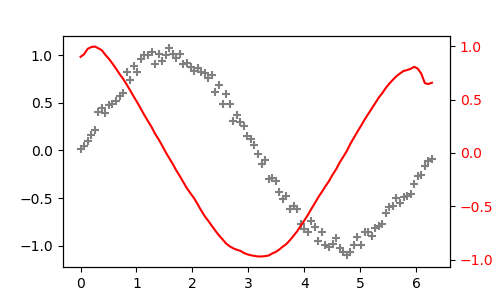

In [78]:
# Data
t = np.linspace(0,2*np.pi,100)
x = np.sin(t) + .1 * (2*np.random.rand(len(t))-1)

# Derivative
pts = list(range(len(x)))
sg_deriv = d_sg.compute_for(t, x, pts)

# Plot on shared axis
fig, ax1 = plt.subplots(1, figsize=[5,3])

h1 = ax1.scatter(t, x, marker='+', color='gray')
ax2 = ax1.twinx()
h2, = ax2.plot(t, list(sg_deriv), color='red')
ax2.tick_params(axis='y', labelcolor='red')

# SINDy examples

## 1-dimensional equation

The point of this notebook is to demonstrate the SINDy code using a simple example from population growth:

The model we want to back out using SINDy will be

$\frac{dP}{dt}=r P \cdot \left(1 - \frac{P}{K}\right)$

where the constant r defines the growth rate and K is the carrying capacity.

This model has a nice closed form solution that we can use to generate data:

$P(t) = \frac{K P_0 e^{rt}}{K + P_0 \left( e^{rt} - 1\right)} = \frac{K}{1+\left(\frac{K-P_0}{P_0}\right)e^{-rt}}$.

### Generate data

<IPython.core.display.Javascript object>


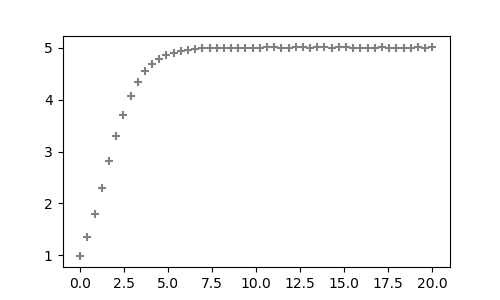

In [492]:
K = 5.
r = 1
P0 = 1
noise = .01

t = np.linspace(0,20,50)
x = K*P0*np.exp(r*t)/(K+P0*(np.exp(r*t)-1)) + noise * (2*np.random.rand(len(t))-1)

fig, ax1 = plt.subplots(1, figsize=[5,3])
ax1.scatter(t, x, color='gray', marker='+')

### Try SINDy

In [509]:
model = skl.linear_model.Lasso(alpha=1e-5, fit_intercept=False)

order = 4
# Library for 1d vector
library = [lambda x, i=i: np.power(x[:,0], i) for i in range(order + 1)]
lib_str = ['$x^{0}$'.format(i) for i in range(order + 1)]

sindy = sd.SINDy({'library': library, 'model': model, 'derivative': d_sg})

(Below) The black/gray show the data and prediction from the SINDy model. The red shows the numerical $\dot{x}$ and the result from multiplying the dictionary times the solution vector.

<IPython.core.display.Javascript object>


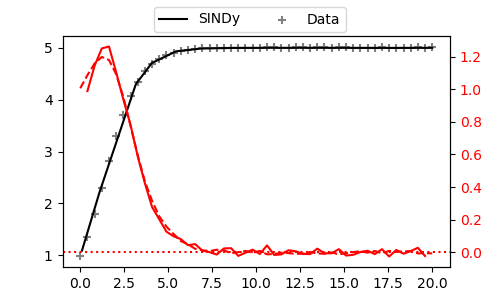

In [510]:
# SINDy
soln = sindy.identify(t, x)

# Integrate SINDy diff-eq
p_t, p_x = sindy.integrate()

# Plot
fig, ax1 = plt.subplots(1, figsize=[5,3])
h1 = ax1.scatter(t, x, color='gray', marker='+')
h2, = ax1.plot(p_t, p_x, color='k')

ax2 = ax1.twinx()
ax2.axhline(0, t.min(), t.max(), color='r', linestyle=':')
h3, = ax2.plot(sindy.t, sindy.ThX@soln, color='r', linestyle='--')
h4, = ax2.plot(sindy.t, sindy.x_dot, color='r')
ax2.tick_params(axis='y', labelcolor='red')

fig.legend([h2, h1], ['SINDy', 'Data'], ncol=2, loc='upper center')

(Below) The SINDy loadings are shown (renormalized so the the initial values match).

Demo how the constant term appears/disappears with fit intercept.

<IPython.core.display.Javascript object>


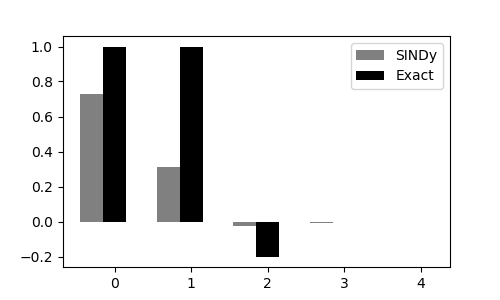

In [511]:
fig, ax = plt.subplots(1, figsize=[5,3])

w = 0.3
index = np.arange(len(soln))

exact = np.zeros(len(index))
exact[0:3] = [P0, r, -r/K]

ax.bar(index-w, soln, width=w, color='gray', align='center')
# ax.bar(index-w, soln/soln[0], width=w, color='gray', align='center')
ax.bar(index, exact, width=w, color='k', align='center')
ax.legend(['SINDy', 'Exact'])

## 2-dimensional equation

See: https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations

### Generate data

In [377]:
params = {
    'x0': 10,
    'y0': 10,
    'prey_growth': 1.1,
    'prey_death': 0.4,
    'predator_growth': 0.1,
    'predator_death': 0.4
}

def lotka_volterra(t, y):
    ydot0 = -params['prey_death']*y[0]*y[1] + params['prey_growth']*y[0]
    ydot1 = -params['predator_death']*y[1] + params['predator_growth']*y[0]*y[1]
    return np.array([ydot0, ydot1])

In [452]:
solver = sp.integrate.solve_ivp(lotka_volterra, [0,50], y0=np.array([10,10]), t_eval=np.linspace(0,50,500))

<IPython.core.display.Javascript object>


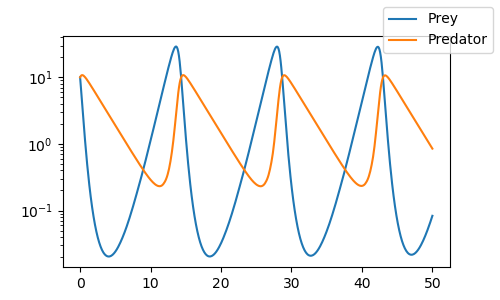

In [453]:
fig, ax = plt.subplots(1, figsize=[5,3])
ax.plot(solver.t, solver.y[0,:])
ax.plot(solver.t, solver.y[1,:])
fig.legend(['Prey', 'Predator'])
ax.set_yscale('log')

Comment from Wikipedia:
These graphs illustrate a serious potential problem with this as a biological model: For this specific choice of parameters, in each cycle, the baboon population is reduced to extremely low numbers, yet recovers (while the cheetah population remains sizeable at the lowest baboon density). In real-life situations, however, chance fluctuations of the discrete numbers of individuals, as well as the family structure and life-cycle of baboons, might cause the baboons to actually go extinct, and, by consequence, the cheetahs as well. This modelling problem has been called the "atto-fox problem", an atto-fox being a notional 10−18 of a fox.

### Try SINDy

In [454]:
X = solver.y.T
t = solver.t

Looking at the generated data, resampling might be a good idea. There are a lot of gaps at the low derivative regions.

<IPython.core.display.Javascript object>


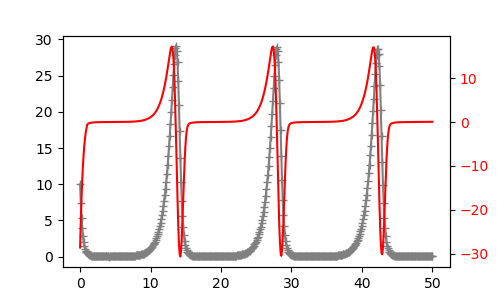

In [455]:
# Piece 1: Derivative

d_sg = sd.SavitzkyGolay({'left': 1, 'right': 1, 'order': 3})
pts = list(range(len(t)))
sg_deriv = d_sg.compute_for(t, X[:,0], pts)

# Plot on shared axis
fig, ax1 = plt.subplots(1, figsize=[5,3])

h1 = ax1.plot(t, X[:,0], marker='+', color='gray')
ax2 = ax1.twinx()
h2, = ax2.plot(t, list(sg_deriv), color='red')
ax2.tick_params(axis='y', labelcolor='red')

The multinomial powers is a nice utility to generate mixed polynomials of the data. Check the documentation for hints. Note that we need to set an initial value to the parameter "powers" in the lambda function to prevent every library function's parameters from referencing the same value at the end of the loop.

In [469]:
# Piece 2: Library

order= 2
library = []

multi_powers = np.array(list(sd.multinomial_powers(order, 2 + 1)))
for powers in multi_powers:
    library.append(lambda x, powers=powers[1:]: 
                   np.product([np.power(x[:, i], p) for i, p in enumerate(powers[1:])], axis=0))

In [476]:
# Piece 3: Loss function (component-wise for now)

model = skl.linear_model.Lasso(alpha=.1, fit_intercept=False)

In [477]:
sindy = sd.SINDy({'library': library, 'model': model, 'derivative': d_sg})

In [478]:
solns = sindy.identify(t,X)

<IPython.core.display.Javascript object>


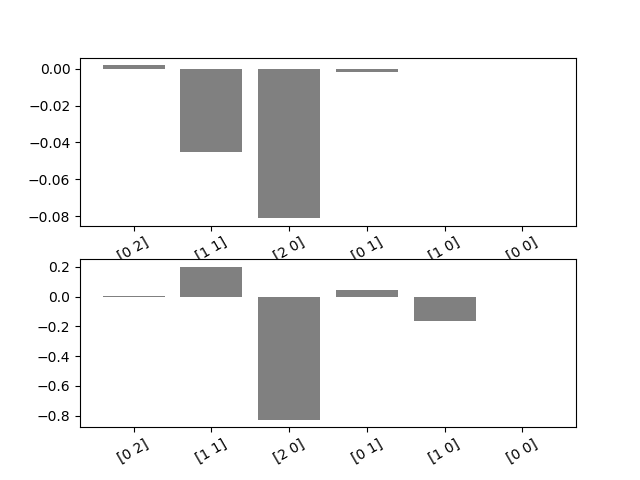

In [479]:
fig, ax = plt.subplots(2, 1)

index = list(range(len(multi_powers)))
for i in range(2):
    ax[i].bar(index, solns[i,:], color='gray', align='center')
    ax[i].set_xticks(index);
    ax[i].set_xticklabels([str(j) for j in multi_powers[:,1:]], rotation=30);

In [474]:
pt, px = sindy.integrate()

<IPython.core.display.Javascript object>


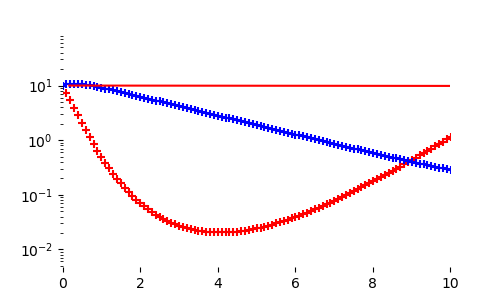

(0, 10)

In [513]:
fig, ax = plt.subplots(1, figsize=[5,3])
ax.scatter(solver.t, solver.y[0,:], color='red', marker='+')
ax.scatter(solver.t, solver.y[1,:], color='blue', marker='+')
fig.legend(['Prey', 'Predator'])
ax.set_yscale('log')

ax.plot(pt, px[:,0], color='red')
ax.plot(pt, px[:,1], color='lenlue')

ax.set_xlim([0,10])